# Import Libararies

In [57]:
#Libraries for 
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Plot the decision tree visualization (optional)
from sklearn.tree import plot_tree
import seaborn as sn
import warnings
from scipy import stats
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
warnings.filterwarnings('ignore')
%matplotlib inline



# Prepare Data

## Import

In [58]:
def wrangle(df):
    # Checking for Info.
    df.info()
    
    # checking for missing values.
    df.isnull().sum()
    df.dropna()
    
     # shift column 'BodyFat' to last_position position 
    last_position = df.pop('BodyFat')  
    df.insert(14, 'BodyFat', last_position) 
   
    # Compute Z-scores for all numeric columns
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))  # Apply Z-score only to numeric columns

    # Identify rows with Z-scores greater than 3 (or less than -3) for any column
    outliers_z = (z_scores > 3).any(axis=1)  # 'any' returns True if any column in the row is an outlier

    # Remove the outliers (keep only rows where outliers_z is False)
    df_cl = df[~outliers_z]
   
   

    # Optionally, save the cleaned dataset to a new CSV file
    df_cl.to_csv('cleaned_body_fat_data.csv', index=False)
    return df_cl

In [59]:
data_cl = wrangle(pd.read_csv('bodyfat.csv'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


## Explore

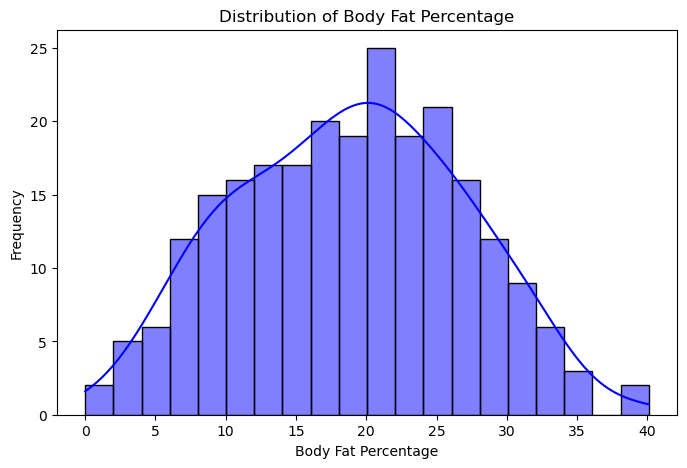

In [60]:
# Example: Distribution of body fat percentage in the dataframe.
plt.figure(figsize=(8, 5))
sn.histplot(data_cl['BodyFat'], kde=True, color='blue', bins=20)
plt.title('Distribution of Body Fat Percentage')
plt.xlabel('Body Fat Percentage')
plt.ylabel('Frequency')
plt.show()

### The X-axis represents the number of individuals within each bin of body fat percentage. The Y-axis represents the frequency and number of individuals with the bins. Each bar height corresponds to number of observations within the percentage range. Most individuals have body fat percentages around the cental peak, likely between 15% and 25%. The above graph shows normal distribution cuvre

### Correlation Heatmap.

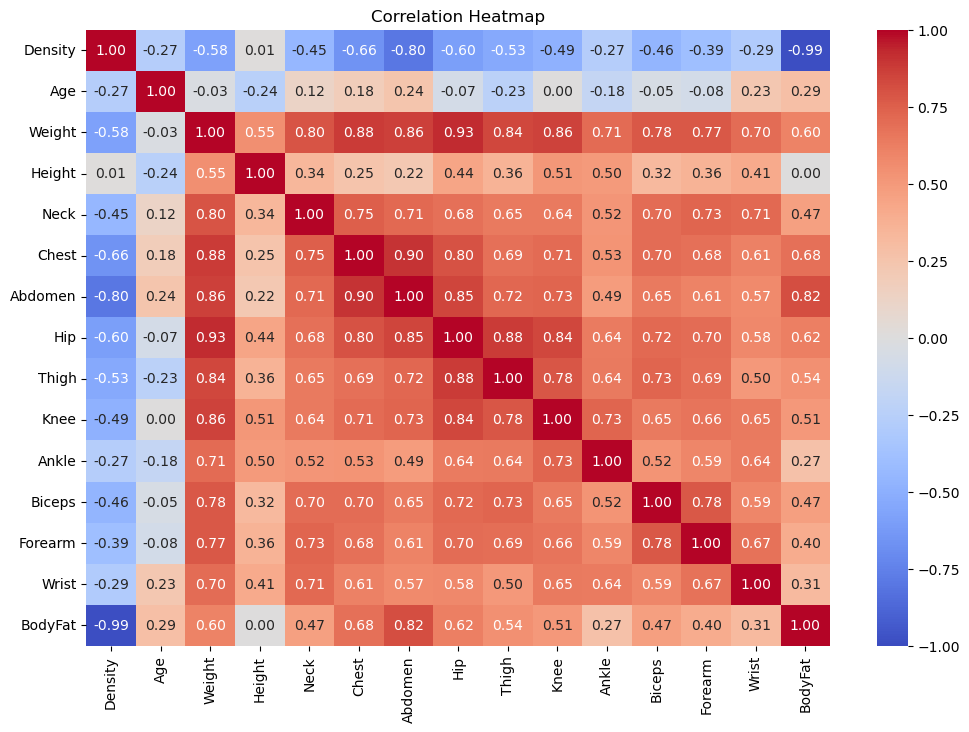

In [61]:
plt.figure(figsize=(12, 8))
sn.heatmap(data_cl.corr(), annot=True, cmap='coolwarm', fmt=".2f",vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [62]:
data_cl

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BodyFat
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.3
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.1
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,25.3
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.4
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.0
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,33.6
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,29.3
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,26.0


## Split Data

In [63]:
X = data_cl.drop(columns=["BodyFat"])
X

y = data_cl["BodyFat"]
y

0      12.3
1       6.1
2      25.3
3      10.4
4      28.7
       ... 
247    11.0
248    33.6
249    29.3
250    26.0
251    31.9
Name: BodyFat, Length: 242, dtype: float64

## Mutual Information Gain. Comparing it with PCA.

<Axes: >

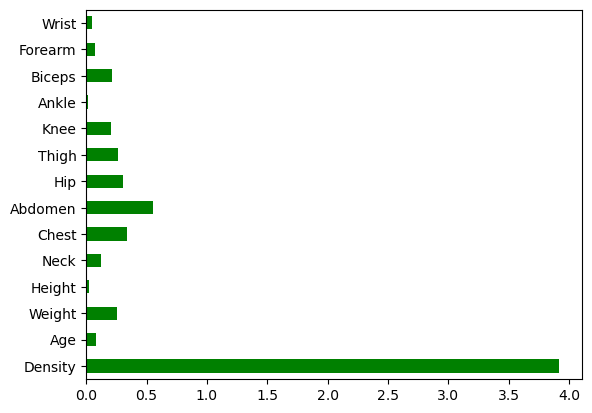

In [64]:
# import mutual info regression.
from sklearn.feature_selection import mutual_info_regression

# instanciate mutual_info_regression.
mr = mutual_info_regression(X, y) 

plot_data = pd.Series(mr, index=X.columns)
plot_data.plot(kind="barh", color="green")

In [65]:
print(plot_data)

Density    3.914216
Age        0.078740
Weight     0.252826
Height     0.024598
Neck       0.119453
Chest      0.335519
Abdomen    0.554874
Hip        0.307095
Thigh      0.262690
Knee       0.208472
Ankle      0.015378
Biceps     0.215716
Forearm    0.071237
Wrist      0.045018
dtype: float64


In [66]:
data_cl

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BodyFat
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.3
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.1
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,25.3
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.4
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.0
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,33.6
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,29.3
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,26.0


In [67]:
y = data_cl['BodyFat']
X = data_cl[["Density","Abdomen","Hip","Chest"]]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build Model.

## Baseline Model.

In [68]:
from sklearn.metrics import mean_absolute_error

In [69]:
y_mean = y_train.mean()
y_mean

18.601775147928993

In [70]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[18.601775147928993,
 18.601775147928993,
 18.601775147928993,
 18.601775147928993,
 18.601775147928993]

The Purpose of this code is to create a simple baseline model that predicts the mean of the target variable for all inputs. This baseline helps evaluate whether more complex models perform better than this naive prediction.



In [71]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("Mean:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean: 18.6
Baseline MAE: 6.75


## Iterate

## Creating the Hybrid models & Seperate model as well.

To make the hyperparameter tuning process faster and more efficient while maintaining accuracy, we can take a few steps:

Reduce the Search Space: Instead of testing a wide range of hyperparameters, we can focus on a smaller, more promising set based on prior knowledge or previous experimentation.

Use RandomizedSearchCV: This approach randomly samples from the hyperparameter grid, making the search more efficient by testing only a subset of the combinations. This can reduce the computational cost, especially when the search space is large.

Use Early Stopping and Reduced Iterations for MLP: Early stopping helps to prevent overfitting, and reducing the number of iterations for MLP (if the model converges early) can speed up training.

In [72]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np

# Hyperparameter tuning for Decision Tree Regressor
dt_param_grid = {
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['squared_error', 'absolute_error'],
    'splitter': ['best'],
    'max_leaf_nodes': [None, 10],
    'min_impurity_decrease': [0.0, 0.01]
}
dt_grid_search = RandomizedSearchCV(DecisionTreeRegressor(), dt_param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)
dt_grid_search.fit(X_train, y_train)
best_dt = dt_grid_search.best_estimator_

# Hyperparameter tuning for Random Forest Regressor
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True],
    'oob_score': [True],
    'warm_start': [True],
}
rf_grid_search = RandomizedSearchCV(RandomForestRegressor(), rf_param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)
rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_

# Hyperparameter tuning for MLP Regressor
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.001],
    'max_iter': [500],
    'batch_size': [16],
    'early_stopping': [True],
    'tol': [1e-4],
}
mlp_grid_search = RandomizedSearchCV(MLPRegressor(max_iter=1000), mlp_param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)
mlp_grid_search.fit(X_train, y_train)
best_mlp = mlp_grid_search.best_estimator_

# Train models with the best parameters
best_dt.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_mlp.fit(X_train, y_train)

# Make predictions
dt_predictions = best_dt.predict(X_test)
rf_predictions = best_rf.predict(X_test)
mlp_predictions = best_mlp.predict(X_test)

# Combine predictions using simple averaging
hybrid_predictions = (dt_predictions + rf_predictions + mlp_predictions) / 3



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [73]:
X_test

,Density,Abdomen,Hip,Chest
24,1.0668,76.3,95.8,90.2
6,1.0549,90.7,100.3,105.1
157,1.0761,90.8,102.5,98.5
217,1.0819,81.5,94.4,93.3
247,1.0736,83.6,88.8,89.2
...,...,...,...,...
200,1.0709,89.2,99.2,102.7
109,1.0500,92.3,100.6,97.8
114,1.0384,92.4,97.5,100.7
205,1.0610,96.3,102.0,105.6


In [74]:
# splitting the above maodel to two's 


Key Changes:
RandomizedSearchCV:

Instead of GridSearchCV, I've replaced it with RandomizedSearchCV, which performs random sampling over the hyperparameter grid. The number of iterations (n_iter=10) is controlled, so it doesn't explore all combinations, but still provides a good balance between search space exploration and computation time.
Reduced Search Space:

I've reduced the range of hyperparameters to make the tuning process faster, without sacrificing much in terms of potential accuracy. For instance, fewer values for max_depth or min_samples_split have been selected.
MLP Regressor Adjustments:

Reduced the number of iterations (max_iter=500) for faster convergence.
Enabled early_stopping=True to stop training if the validation score stops improving.
By using RandomizedSearchCV and narrowing down the hyperparameter search space, the process will be more efficient while still exploring a range of hyperparameters to find an optimal model.

## Evaluate

In [75]:
mae_dt_ind = mean_absolute_error(y_test, dt_predictions)
rmse_dt_ind = np.sqrt(mean_squared_error(y_test, dt_predictions))

mae_rf_ind = mean_absolute_error(y_test, rf_predictions)
rmse_rf_ind = np.sqrt(mean_squared_error(y_test, rf_predictions))

mae_mlp_ind = mean_absolute_error(y_test, mlp_predictions)
rmse_mlp_ind = np.sqrt(mean_squared_error(y_test, mlp_predictions))

print(f'Mean Absolute Error_dt_individual: {mae_dt_ind}')
print(f'Root Mean Squared Error: {rmse_dt_ind}')
print("\n")

print(f'Mean Absolute Error_rf_individual: {mae_rf_ind}')
print(f'Root Mean Squared Error: {rmse_rf_ind}')
print("\n")

print(f'Mean Absolute Error_mlp_individual: {mae_mlp_ind}')
print(f'Root Mean Squared Error: {rmse_mlp_ind}')
print("\n")

# Evaluate the hybrid model.
mae_hybrid = mean_absolute_error(y_test, hybrid_predictions)
rmse_hybrid = np.sqrt(mean_squared_error(y_test, hybrid_predictions))

print(f'Mean Absolute Error: {mae_hybrid}')
print(f'Root Mean Squared Error: {rmse_hybrid}')

# Save the hybrid model using pickle
hybrid_model = {
    'decision_tree': best_dt,
    'random_forest': best_rf,
    'mlp': best_mlp
}


Mean Absolute Error_dt_individual: 1.9869863013698632
Root Mean Squared Error: 3.0516613485610375


Mean Absolute Error_rf_individual: 0.6772876712328766
Root Mean Squared Error: 1.1249491678013621


Mean Absolute Error_mlp_individual: 5.5935127539423615
Root Mean Squared Error: 6.736041057140094


Mean Absolute Error: 2.2660722203171715
Root Mean Squared Error: 2.9630020732101725


# Communicate Results.

KeyError: 1

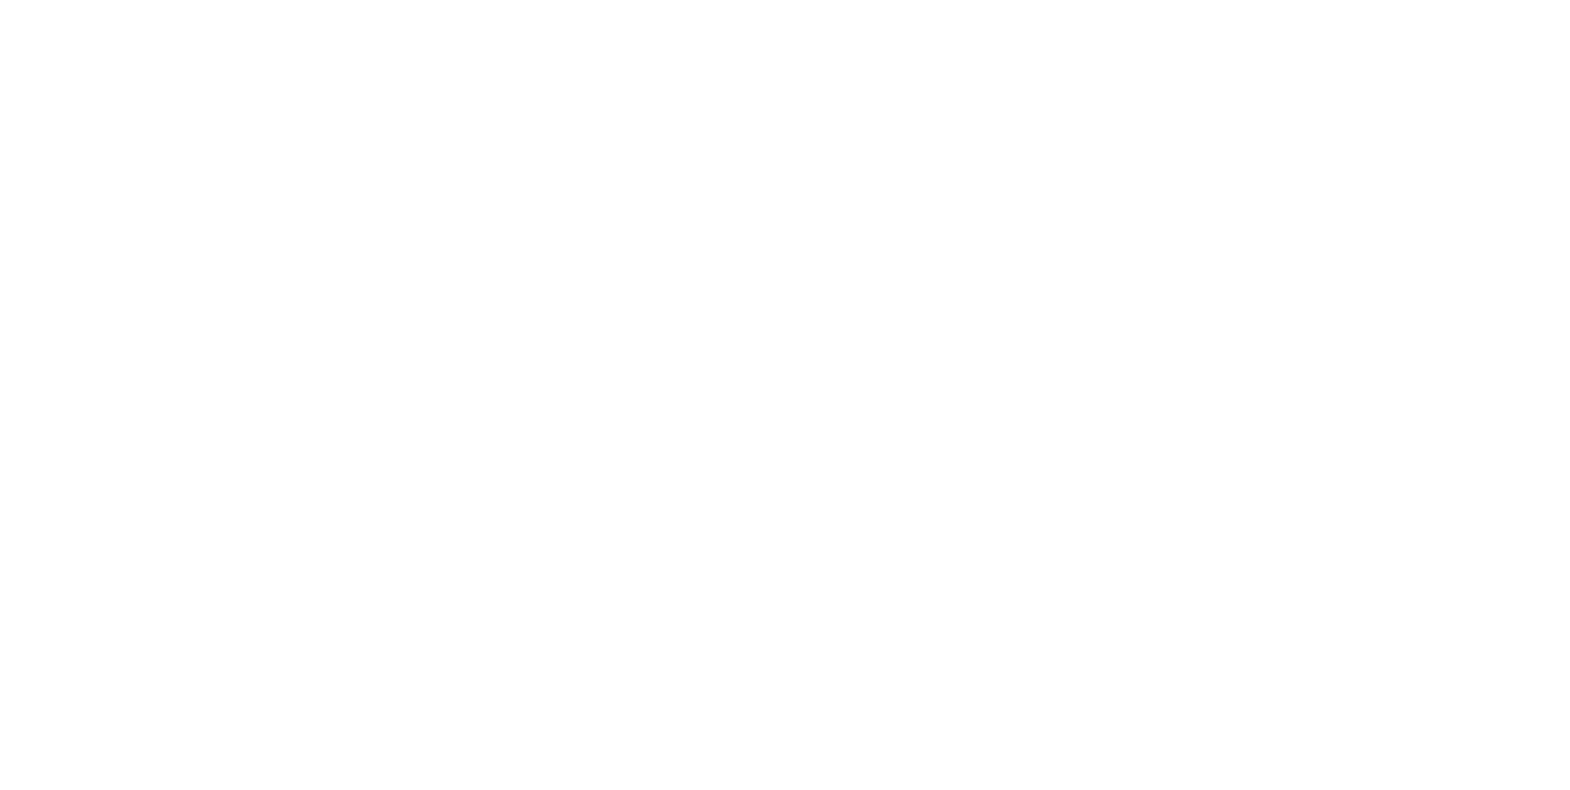

In [76]:
# Plot decision tree
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=X, filled=True, rounded=True)
plt.title("Decision Tree for Body Fat Prediction")
plt.show()

# pruning the tree.


In [ ]:
data_cl

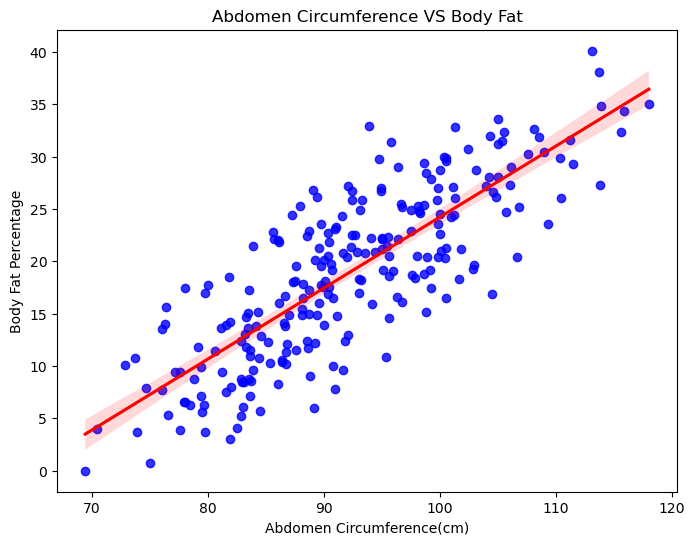

In [77]:
plt.figure(figsize=(8, 6))
sn.regplot(x=data_cl["Abdomen"], y=data_cl["BodyFat"], data=data_cl, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title("Abdomen Circumference VS Body Fat")
plt.xlabel("Abdomen Circumference(cm)")
plt.ylabel("Body Fat Percentage")
plt.grid(False)
plt.show()

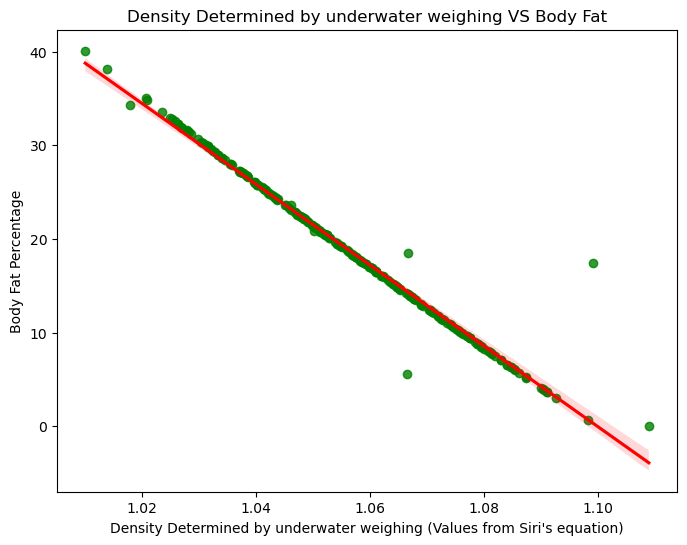

In [78]:
plt.figure(figsize=(8, 6))
sn.regplot(x=data_cl["Density"], y=data_cl["BodyFat"], data=data_cl, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title("Density Determined by underwater weighing VS Body Fat")
plt.xlabel("Density Determined by underwater weighing (Values from Siri's equation)")
plt.ylabel("Body Fat Percentage")
plt.grid(False)
plt.show()

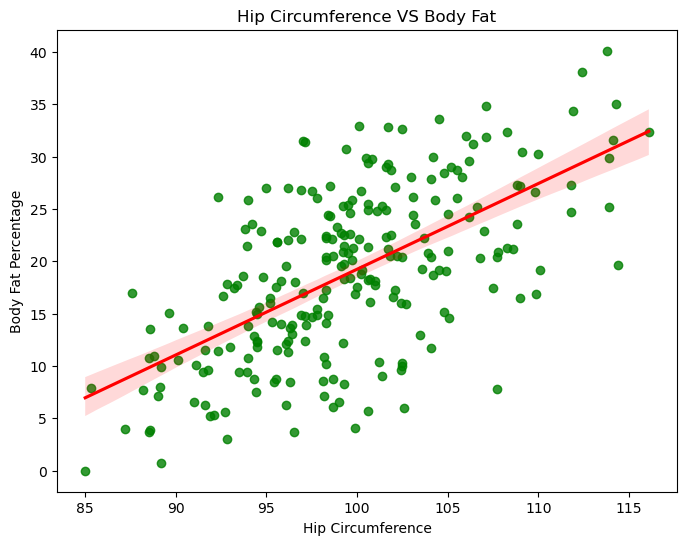

In [79]:
plt.figure(figsize=(8, 6))
sn.regplot(x=data_cl["Hip"], y=data_cl["BodyFat"], data=data_cl, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title("Hip Circumference VS Body Fat")
plt.xlabel("Hip Circumference")
plt.ylabel("Body Fat Percentage")
plt.grid(False)
plt.show()

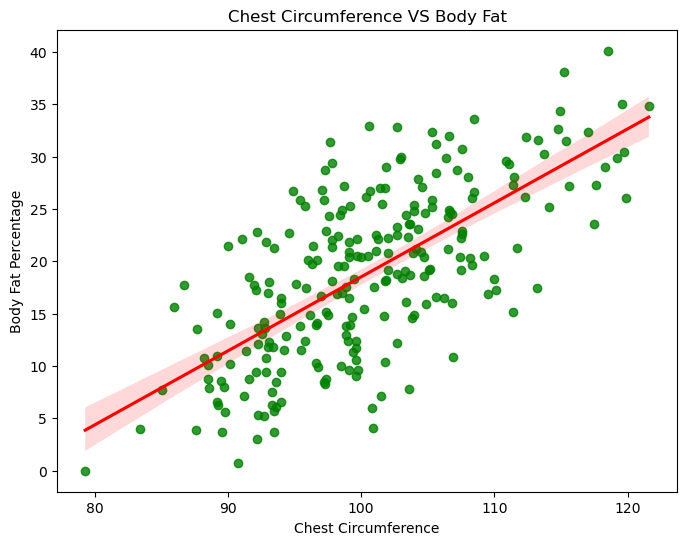

In [80]:
plt.figure(figsize=(8, 6))
sn.regplot(x=data_cl["Chest"], y=data_cl["BodyFat"], data=data_cl, scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title("Chest Circumference VS Body Fat")
plt.xlabel("Chest Circumference")
plt.ylabel("Body Fat Percentage")
plt.grid(False)
plt.show()

In [81]:
with open('hybrid_model.pkl', 'wb') as file:
    pickle.dump(hybrid_model, file)

print("Hybrid model saved as hybrid_model.pkl")

Hybrid model saved as hybrid_model.pkl
